# 08d – New Endoscopy Site Selection

This notebook identifies optimal new locations for endoscopy capacity to address areas with **Low** or **Marginal** access (i.e., <4.0 rooms per 100,000 people aged 50–74). We implement and compare two strategies:

---

## Spatial Clustering (DBSCAN or Hexbin)

**Plain English Description:**
This method identifies clusters of underserved LSOAs (based on location, population, and access score) using spatial clustering techniques like **DBSCAN** or **hexbin aggregation**. A new site is proposed at the centroid of each cluster.

**Rationale:**
- Targets groups of underserved areas rather than single extremes.
- Prioritises consistent spatial gaps, especially in rural or edge-of-region zones.
- Clustering avoids over-concentrating new sites in dense urban cores.

---

In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and File Paths
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")

# Define base and sub-directory paths
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
raw_dir = os.path.join(data_dir, "raw")
proc_dir = os.path.join(data_dir, "processed", "endoscopy")

# Define input file paths
gpkg_path = os.path.join(raw_dir, "LSOA_5-year_segment_master.gpkg")
access_path = os.path.join(proc_dir, "lsoa_competition_access.gpkg")
travel_path = os.path.join(proc_dir, "travel_times_filtered.csv")
facilities_path = os.path.join(proc_dir, "facilities_with_geometry.gpkg")
travel_csv_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")

# Load data
access_gdf = gpd.read_file(access_path)
lsoa_gdf = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# CRS alignment
access_gdf = access_gdf.to_crs(lsoa_gdf.crs)

# Filter underserved LSOAs (Low or Marginal access)
underserved_gdf = access_gdf[access_gdf["access_flag"].isin(["Low", "Marginal", "No Access"])].copy()

# Merge geometry onto underserved areas
underserved_gdf = underserved_gdf.merge(
    lsoa_gdf,
    on="lsoa21cd",
    how="left"
)

# Merge geometry onto underserved areas
underserved_gdf = underserved_gdf.merge(
    lsoa_gdf,
    on="lsoa21cd",
    how="left"
)

# Set correct geometry column
underserved_gdf = underserved_gdf.set_geometry("geometry")

# Reproject to British National Grid for clustering
underserved_gdf = underserved_gdf.to_crs(epsg=27700)


# Preview
print(f"Underserved LSOAs loaded: {underserved_gdf.shape[0]}")
underserved_gdf[["lsoa21cd", "rooms_per_100k_competition", "access_flag"]].head()


Underserved LSOAs loaded: 2065


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01020484,2.295663,Low
1,E01020481,0.999220,Low
2,E01020482,2.295663,Low
3,E01020479,2.295663,Low
4,E01020478,2.295663,Low


## Step 1a – Preview Map of Underserved LSOAs (Low + Marginal Access)

Before applying DBSCAN clustering, we visualise the spatial distribution of underserved LSOAs across the NHS South West region.

This helps confirm:
- That underserved areas form potential clusters
- The spread across urban/rural settings
- Any edge effects (e.g. eastern boundary LSOAs near other NHS regions)

The map colours LSOAs by access flag (`Low`, `Marginal`) and overlays existing facility locations.


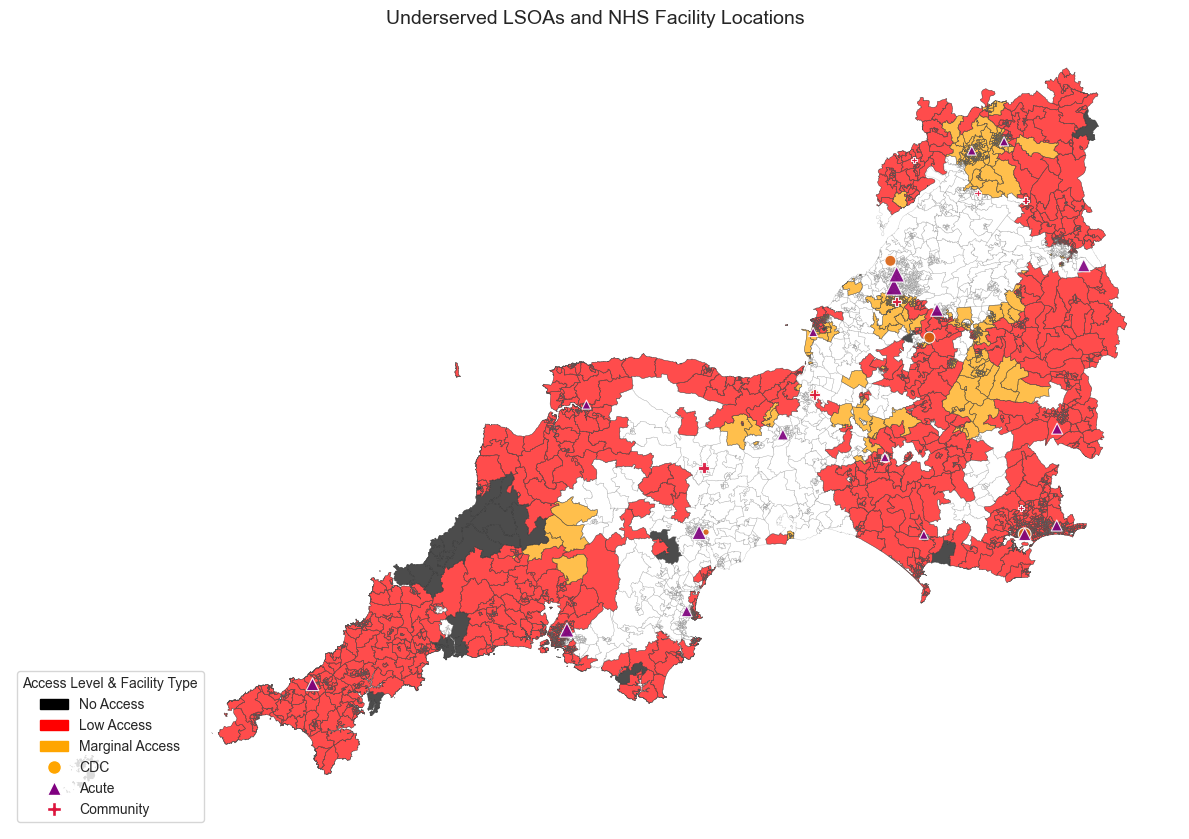

In [5]:
# ----------------------------------------------------------
# Step 1a – Visual Preview: Underserved LSOAs + NHS Facilities
# (Updates: No Access = black; legend bottom-left; CDC=orange, Acute=purple, Community=crimson;
#  points +40% size; stronger white outline; 300 dpi export)
# ----------------------------------------------------------

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Reproject facility and boundary data to match
facilities_gdf = gpd.read_file(facilities_path).to_crs(epsg=27700)
lsoa_borders = lsoa_gdf.to_crs(epsg=27700).boundary
underserved_plot = underserved_gdf.to_crs(epsg=27700).copy()

# Colour map for access types (No → Low → Marginal)
# No Access now BLACK
cmap = ListedColormap(["black", "red", "orange"])
access_order = ["No Access", "Low", "Marginal"]
access_code_map = {"No Access": 0, "Low": 1, "Marginal": 2}
underserved_plot["access_code"] = underserved_plot["access_flag"].map(access_code_map)

# Set up plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot underserved LSOAs (categorical)
underserved_plot.plot(
    ax=ax,
    column="access_code",
    cmap=cmap,
    linewidth=0.3,
    edgecolor="black",
    alpha=0.7,
    legend=False
)

# Overlay LSOA borders
lsoa_borders.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.4
)

# Overlay NHS facilities by type (updated colours; +40% size; stronger white outline)
for label, colour, marker in [
    ("CDC", "#d95f0e", "o"),
    ("Acute", "purple", "^"),
    ("Community", "crimson", "P"),
]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * (15 * 1.4),  # 40% bigger → 21 per room
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white",
        linewidth=0.8,   # stronger white outline
        zorder=3
    )

# Custom legend (updated colours; bottom-left)
access_patches = [
    mpatches.Patch(color='black', label='No Access'),
    mpatches.Patch(color='red', label='Low Access'),
    mpatches.Patch(color='orange', label='Marginal Access')
]
facility_handles = [
    plt.Line2D(
        [0], [0], marker=mk, linestyle='',
        markerfacecolor=col, markeredgecolor='white', markeredgewidth=1.0,
        markersize=10, label=lbl
    )
    for lbl, col, mk in [("CDC", "orange", "o"), ("Acute", "purple", "^"), ("Community", "crimson", "P")]
]

ax.legend(
    handles=access_patches + facility_handles,
    title="Access Level & Facility Type",
    loc="lower left",
    frameon=True
)

# Final formatting
ax.set_title("Underserved LSOAs and NHS Facility Locations", fontsize=14)
ax.axis("off")
plt.tight_layout()

# 300 dpi export
fig.savefig("Underserved_LSOAs_and_Facilities.png", dpi=300, bbox_inches="tight")

plt.show()


In [3]:
# ----------------------------------------------------------
# Step 2 – Filter, Cluster, and Package Underserved LSOAs (KMeans for k = 3 to 7)
# ----------------------------------------------------------

from sklearn.cluster import KMeans
import numpy as np

# Filter underserved LSOAs with target-age population
filtered_gdf = underserved_gdf[underserved_gdf["pop_50_74"] > 0].copy()

# Compute centroids and extract coordinates
filtered_gdf["centroid"] = filtered_gdf.geometry.centroid
coords = np.array(list(filtered_gdf["centroid"].apply(lambda p: (p.x, p.y))))

# Store results per cluster count
cluster_results = {}

# Minimum cluster size
min_cluster_size = 50

# Loop through k = 3 to 7
for k in range(3, 8):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(coords)

    clustered = filtered_gdf.copy()
    clustered["cluster"] = labels

    # Count LSOAs per cluster
    cluster_counts = clustered["cluster"].value_counts()

    # Filter out clusters smaller than the minimum
    valid_clusters = cluster_counts[cluster_counts >= min_cluster_size].index.tolist()
    clustered = clustered[clustered["cluster"].isin(valid_clusters)].copy()

    # Store result
    cluster_results[k] = clustered

    print(f"k = {k}: {len(valid_clusters)} clusters retained (≥ {min_cluster_size} LSOAs)")


/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

k = 3: 3 clusters retained (≥ 50 LSOAs)
k = 4: 4 clusters retained (≥ 50 LSOAs)
k = 5: 5 clusters retained (≥ 50 LSOAs)
k = 6: 6 clusters retained (≥ 50 LSOAs)
k = 7: 7 clusters retained (≥ 50 LSOAs)


In [6]:
# ----------------------------------------------------------
# Step 2a – Store Per-Cluster LSOA Groupings for k = 3–7
# ----------------------------------------------------------

# Dictionary to hold cluster groupings for each k
cluster_lsoa_lookup_by_k = {}

for k in range(3, 8):
    clustered_k = cluster_results[k]
    cluster_lsoa_lookup = {
        c: df.reset_index(drop=True)
        for c, df in clustered_k.groupby("cluster")
    }
    cluster_lsoa_lookup_by_k[k] = cluster_lsoa_lookup

# Preview: safely view the first available cluster for k=5
example_k = 5
lookup = cluster_lsoa_lookup_by_k[example_k]
example_cluster = next(iter(lookup))  # get the first valid cluster ID

print(f"\nPreview for k={example_k}, cluster={example_cluster}:")
display(lookup[example_cluster][["lsoa21cd", "pop_50_74", "access_flag"]].head())



Preview for k=5, cluster=0:


,lsoa21cd,pop_50_74,access_flag
0,E01020550,755.06,Low
1,E01020497,814.08,Low
2,E01034380,581.06,Low
3,E01020547,386.70,Low
4,E01020530,883.28,Low


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_18137/1859881720.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", n_clusters)
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_18137/1859881720.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", n_clusters)
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_18137/1859881720.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_

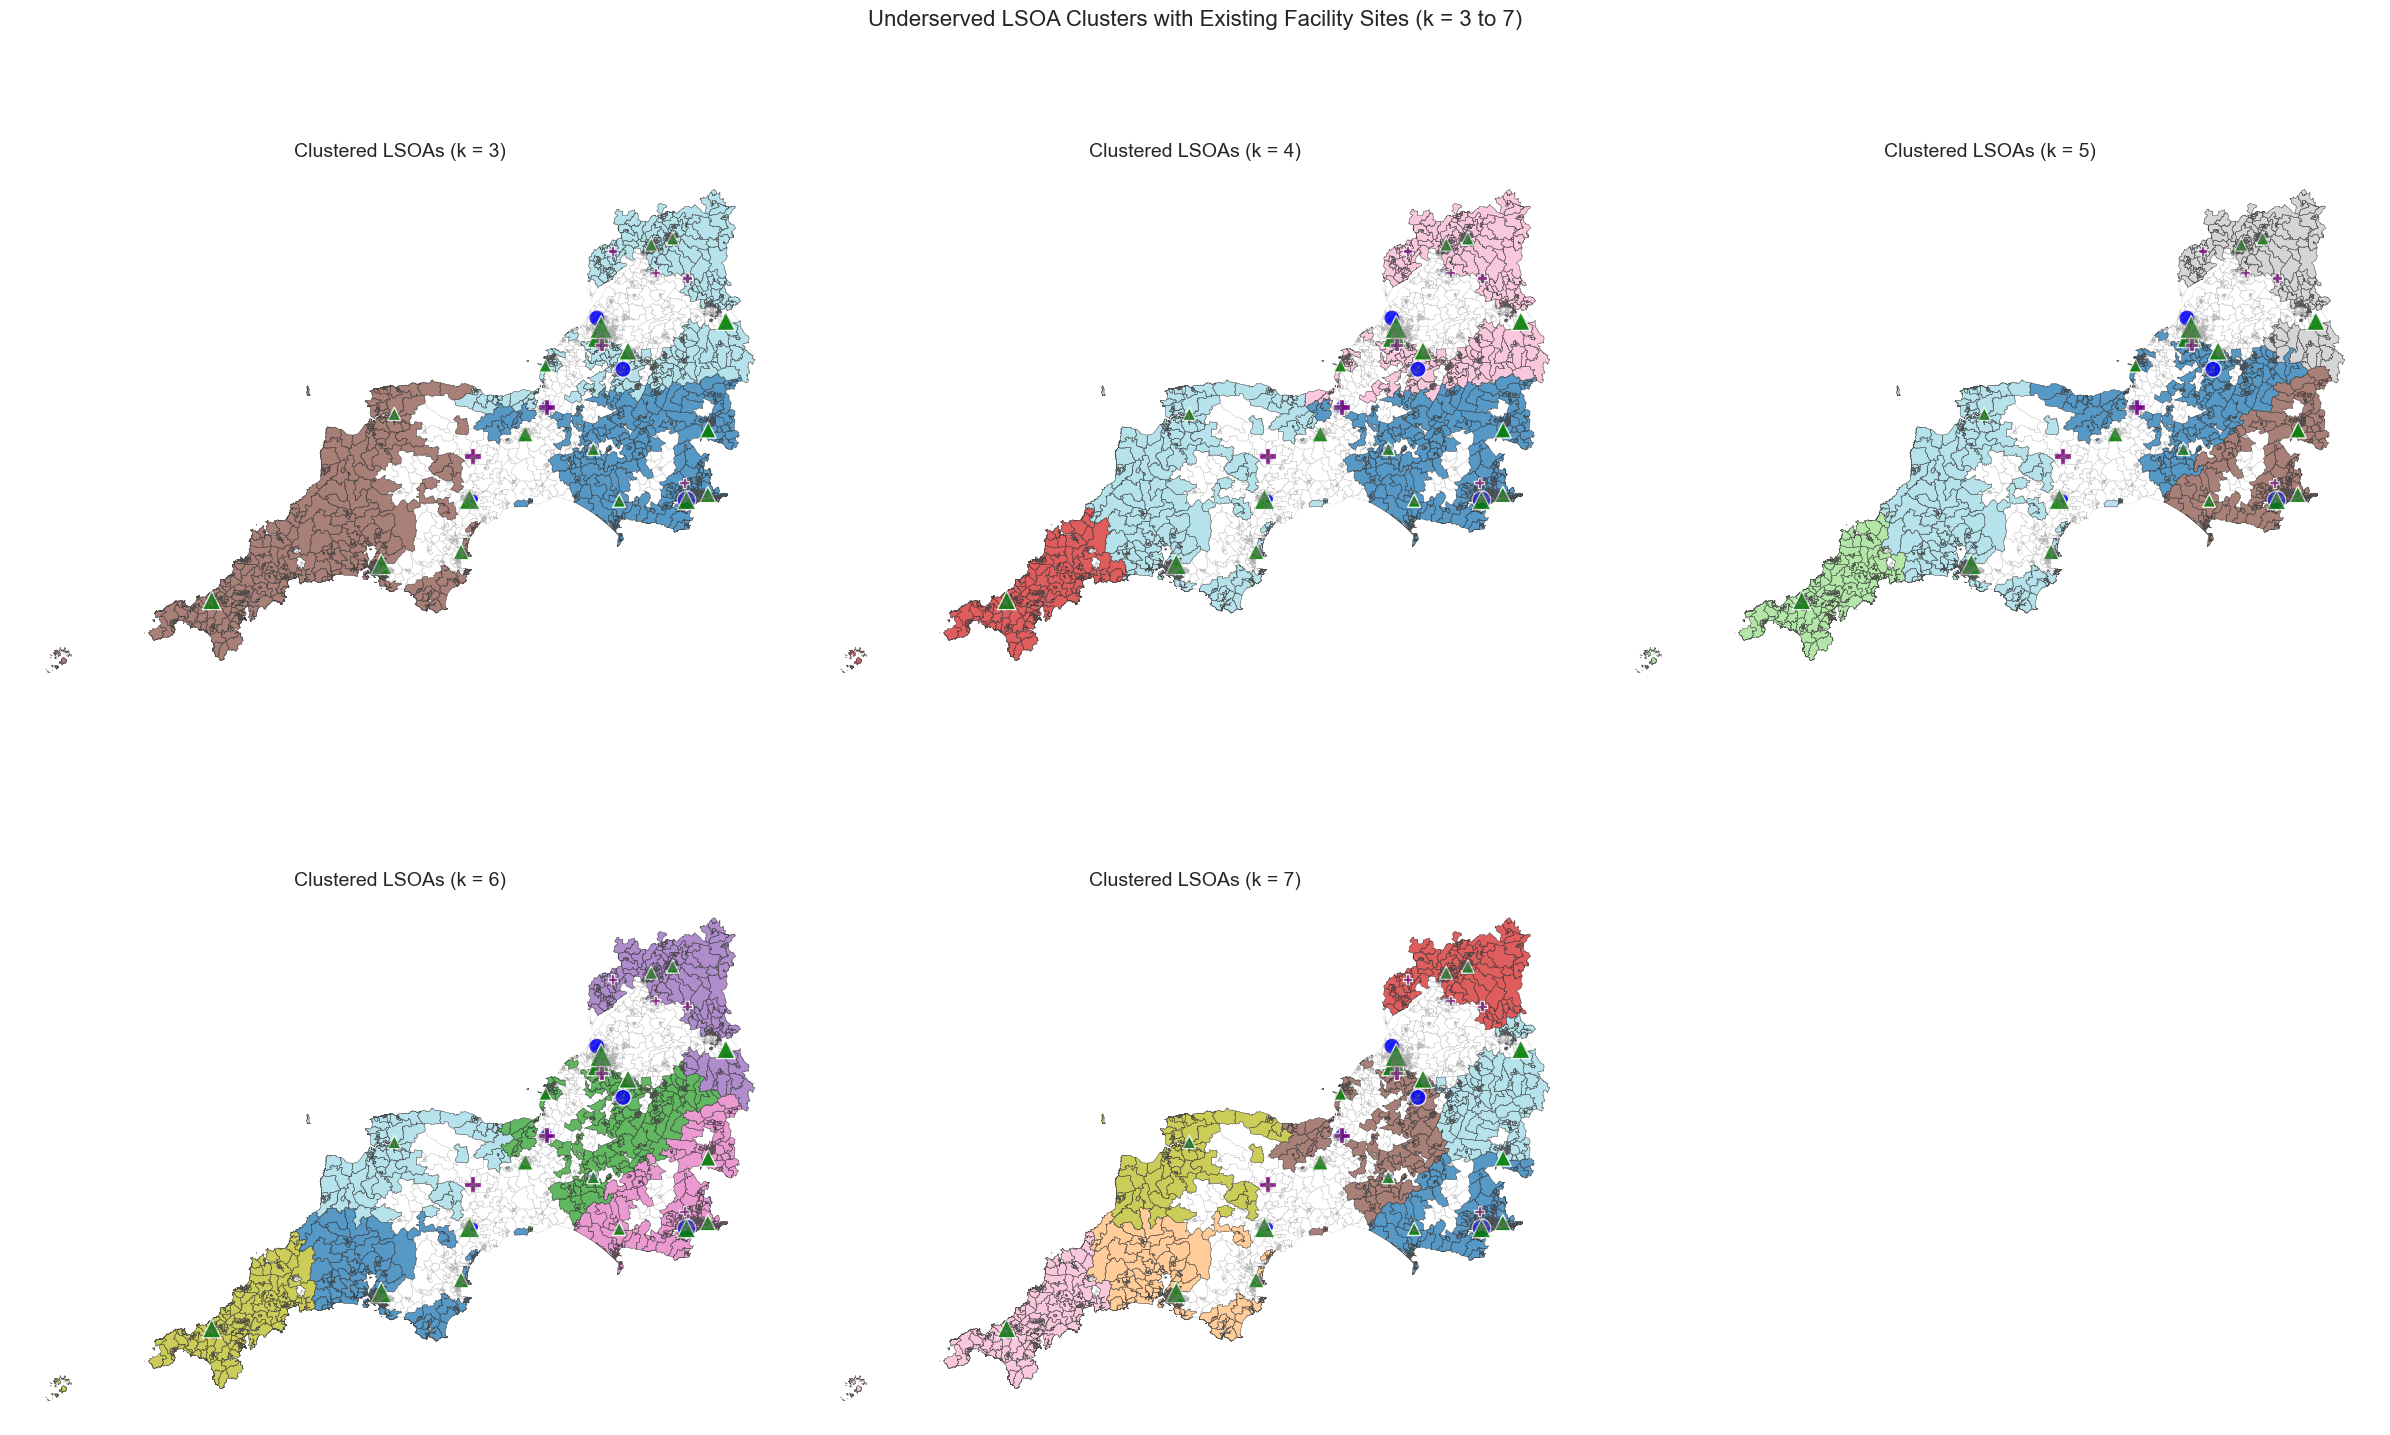

In [7]:
# ----------------------------------------------------------
# Step 2d – Plot Clustered LSOAs and Facility Sites (k = 3 to 7)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

for i, k in enumerate(range(3, 8)):
    ax = axes[i]
    clustered_gdf = cluster_results[k]
    clustered_gdf = clustered_gdf.to_crs(epsg=27700)

    # Get unique cluster count
    unique_clusters = clustered_gdf["cluster"].unique()
    n_clusters = len(unique_clusters)

    # Set up colour map for clusters
    cmap = cm.get_cmap("tab20", n_clusters)
    norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, n_clusters + 0.5, 1), ncolors=n_clusters)

    # Plot LSOA clusters
    clustered_gdf.plot(
        ax=ax,
        column="cluster",
        cmap=cmap,
        norm=norm,
        legend=False,
        edgecolor="black",
        linewidth=0.3,
        alpha=0.75
    )

    # Add base boundary layer
    lsoa_gdf.to_crs(epsg=27700).boundary.plot(
        ax=ax,
        linewidth=0.3,
        color="grey",
        alpha=0.3
    )

    # Overlay facility sites by type
    for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
        subset = facilities_gdf[facilities_gdf["source"] == label].to_crs(epsg=27700)
        subset.plot(
            ax=ax,
            color=colour,
            markersize=subset["Endoscopy Rooms"] * 45,
            marker=marker,
            label=label,
            alpha=0.9,
            edgecolor="white"
        )

    # Format each subplot
    ax.set_title(f"Clustered LSOAs (k = {k})", fontsize=14)
    ax.axis("off")

# Remove extra empty subplot (only 5 used in 2x3 grid)
if len(axes) > 5:
    for j in range(5, len(axes)):
        fig.delaxes(axes[j])

plt.suptitle("Underserved LSOA Clusters with Existing Facility Sites (k = 3 to 7)", fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
# ----------------------------------------------------------
# Step 2b – Identify Optimal LSOA per Cluster Using Travel Time for k=3 to 7
# ----------------------------------------------------------

ISLES_OF_SCILLY_CODE = "E01019077"

# Load travel time matrix
travel_df = pd.read_csv(travel_csv_path)
travel_df[["origin_name", "destination_name"]] = travel_df[["origin_name", "destination_name"]].astype(str)

optimal_sites_gdf_by_k = {}
skipped_clusters_by_k = {}
cluster_sizes_by_k = {}

for k in range(3, 8):
    print(f"\nProcessing k = {k}")
    
    clustered_gdf = cluster_results[k]
    cluster_lsoa_lookup = {
        cluster_id: group.reset_index(drop=True)
        for cluster_id, group in clustered_gdf.groupby("cluster")
    }
    
    optimal_sites = []
    skipped_clusters = []
    cluster_sizes = {}

    for cluster_id, df in cluster_lsoa_lookup.items():
        lsoa_ids = df["lsoa21cd"].astype(str).tolist()
        
        # Exclude Isles of Scilly early
        lsoa_ids = [lsoa for lsoa in lsoa_ids if lsoa != ISLES_OF_SCILLY_CODE]
        
        cluster_sizes[cluster_id] = len(lsoa_ids)

        cluster_travel = travel_df[
            (travel_df["origin_name"].isin(lsoa_ids)) &
            (travel_df["destination_name"].isin(lsoa_ids)) &
            (travel_df["origin_name"] != travel_df["destination_name"])
        ].copy()

        if cluster_travel.empty:
            print(f"Cluster {cluster_id} – no valid travel pairs. Using fallback.")
            skipped_clusters.append(cluster_id)
            fallback = df.iloc[0]
            # Ensure fallback is not Isles of Scilly
            if fallback["lsoa21cd"] == ISLES_OF_SCILLY_CODE:
                fallback = df[df["lsoa21cd"] != ISLES_OF_SCILLY_CODE].iloc[0]
            optimal_sites.append({
                "cluster": cluster_id,
                "lsoa21cd": fallback["lsoa21cd"],
                "travel_time_sum": None,
                "pop_50_74": fallback["pop_50_74"],
                "geometry": fallback["geometry"]
            })
            continue

        total_travel = (
            cluster_travel.groupby("origin_name")["travel_time_car"]
            .sum()
            .reset_index()
            .rename(columns={"origin_name": "lsoa21cd", "travel_time_car": "travel_time_sum"})
        )

        valid_travel = total_travel[total_travel["travel_time_sum"] > 0].copy()

        if valid_travel.empty:
            print(f"Cluster {cluster_id} – all LSOAs have zero travel time. Using fallback.")
            skipped_clusters.append(cluster_id)
            fallback = df.iloc[0]
            if fallback["lsoa21cd"] == ISLES_OF_SCILLY_CODE:
                fallback = df[df["lsoa21cd"] != ISLES_OF_SCILLY_CODE].iloc[0]
            optimal_sites.append({
                "cluster": cluster_id,
                "lsoa21cd": fallback["lsoa21cd"],
                "travel_time_sum": None,
                "pop_50_74": fallback["pop_50_74"],
                "geometry": fallback["geometry"]
            })
            continue

        best_lsoa = (
            valid_travel.merge(df, on="lsoa21cd", how="left")
            .sort_values("travel_time_sum")
            .iloc[0]
        )

        optimal_sites.append({
            "cluster": cluster_id,
            "lsoa21cd": best_lsoa["lsoa21cd"],
            "travel_time_sum": best_lsoa["travel_time_sum"],
            "pop_50_74": best_lsoa["pop_50_74"],
            "geometry": best_lsoa["geometry"]
        })

    optimal_sites_gdf = gpd.GeoDataFrame(optimal_sites, geometry="geometry", crs=clustered_gdf.crs)
    optimal_sites_gdf_by_k[k] = optimal_sites_gdf
    skipped_clusters_by_k[k] = skipped_clusters
    cluster_sizes_by_k[k] = cluster_sizes

    # Diagnostics per k
    print(f"k = {k}:")
    print(f"  Clusters processed: {len(cluster_lsoa_lookup)}")
    print(f"  Clusters skipped: {len(skipped_clusters)} → {skipped_clusters if skipped_clusters else 'None'}")
    print(f"  Cluster sizes summary:")
    for cid, size in sorted(cluster_sizes.items()):
        print(f"    Cluster {cid}: {size} LSOAs")
    print(f"  Travel time summary:")
    print(optimal_sites_gdf["travel_time_sum"].describe().round(2))




Processing k = 3
k = 3:
  Clusters processed: 3
  Clusters skipped: 0 → None
  Cluster sizes summary:
    Cluster 0: 654 LSOAs
    Cluster 1: 640 LSOAs
    Cluster 2: 768 LSOAs
  Travel time summary:
count        3.00
mean     31643.72
std       6429.95
min      24237.16
25%      29567.72
50%      34898.27
75%      35347.00
max      35795.74
Name: travel_time_sum, dtype: float64

Processing k = 4
k = 4:
  Clusters processed: 4
  Clusters skipped: 0 → None
  Cluster sizes summary:
    Cluster 0: 645 LSOAs
    Cluster 1: 254 LSOAs
    Cluster 2: 746 LSOAs
    Cluster 3: 417 LSOAs
  Travel time summary:
count        4.00
mean     21000.72
std      10414.01
min       7124.86
25%      17801.56
50%      22286.33
75%      25485.49
max      32305.37
Name: travel_time_sum, dtype: float64

Processing k = 5
k = 5:
  Clusters processed: 5
  Clusters skipped: 0 → None
  Cluster sizes summary:
    Cluster 0: 477 LSOAs
    Cluster 1: 249 LSOAs
    Cluster 2: 516 LSOAs
    Cluster 3: 429 LSOAs
    Cl

In [9]:
# ----------------------------------------------------------
# Step 2c – Convert optimal sites GeoDataFrames to DataFrames and add centroid coordinates
# ----------------------------------------------------------

optimal_sites_df_by_k = {}

for k, gdf in optimal_sites_gdf_by_k.items():
    df = pd.DataFrame(gdf)

    clustered_gdf = cluster_results[k].copy()
    if "centroid" not in clustered_gdf.columns:
        clustered_gdf["centroid"] = clustered_gdf.geometry.centroid

    df = df.merge(
        clustered_gdf[["lsoa21cd", "centroid"]],
        on="lsoa21cd",
        how="left"
    )
    df["centroid_x"] = df["centroid"].apply(lambda p: p.x)
    df["centroid_y"] = df["centroid"].apply(lambda p: p.y)

    optimal_sites_df_by_k[k] = df

In [10]:
# ----------------------------------------------------------
# Now you can inspect or plot using optimal_sites_gdf_by_k or optimal_sites_df_by_k
# Example inspect for k=5:
gdf = optimal_sites_gdf_by_k[5]

print("\nOptimal LSOAs Selected (k=5):")
display(gdf[["cluster", "lsoa21cd", "travel_time_sum", "pop_50_74"]])

print("LSOAs selected per cluster:")
for idx, row in gdf.iterrows():
    travel_time = row['travel_time_sum']
    travel_time_str = f"{travel_time:.2f}" if travel_time is not None else "N/A"
    print(f"  Cluster {row['cluster']}: {row['lsoa21cd']} (Travel time sum: {travel_time_str}, Pop 50-74: {row['pop_50_74']:.1f})")


Optimal LSOAs Selected (k=5):


,cluster,lsoa21cd,travel_time_sum,pop_50_74
0,0,E01029064,19234.836759,553.57
1,1,E01018910,6813.452194,526.10
2,2,E01015433,14121.844697,640.07
3,3,E01022454,10754.449175,792.70
4,4,E01015143,18193.421156,463.00


LSOAs selected per cluster:
  Cluster 0: E01029064 (Travel time sum: 19234.84, Pop 50-74: 553.6)
  Cluster 1: E01018910 (Travel time sum: 6813.45, Pop 50-74: 526.1)
  Cluster 2: E01015433 (Travel time sum: 14121.84, Pop 50-74: 640.1)
  Cluster 3: E01022454 (Travel time sum: 10754.45, Pop 50-74: 792.7)
  Cluster 4: E01015143 (Travel time sum: 18193.42, Pop 50-74: 463.0)


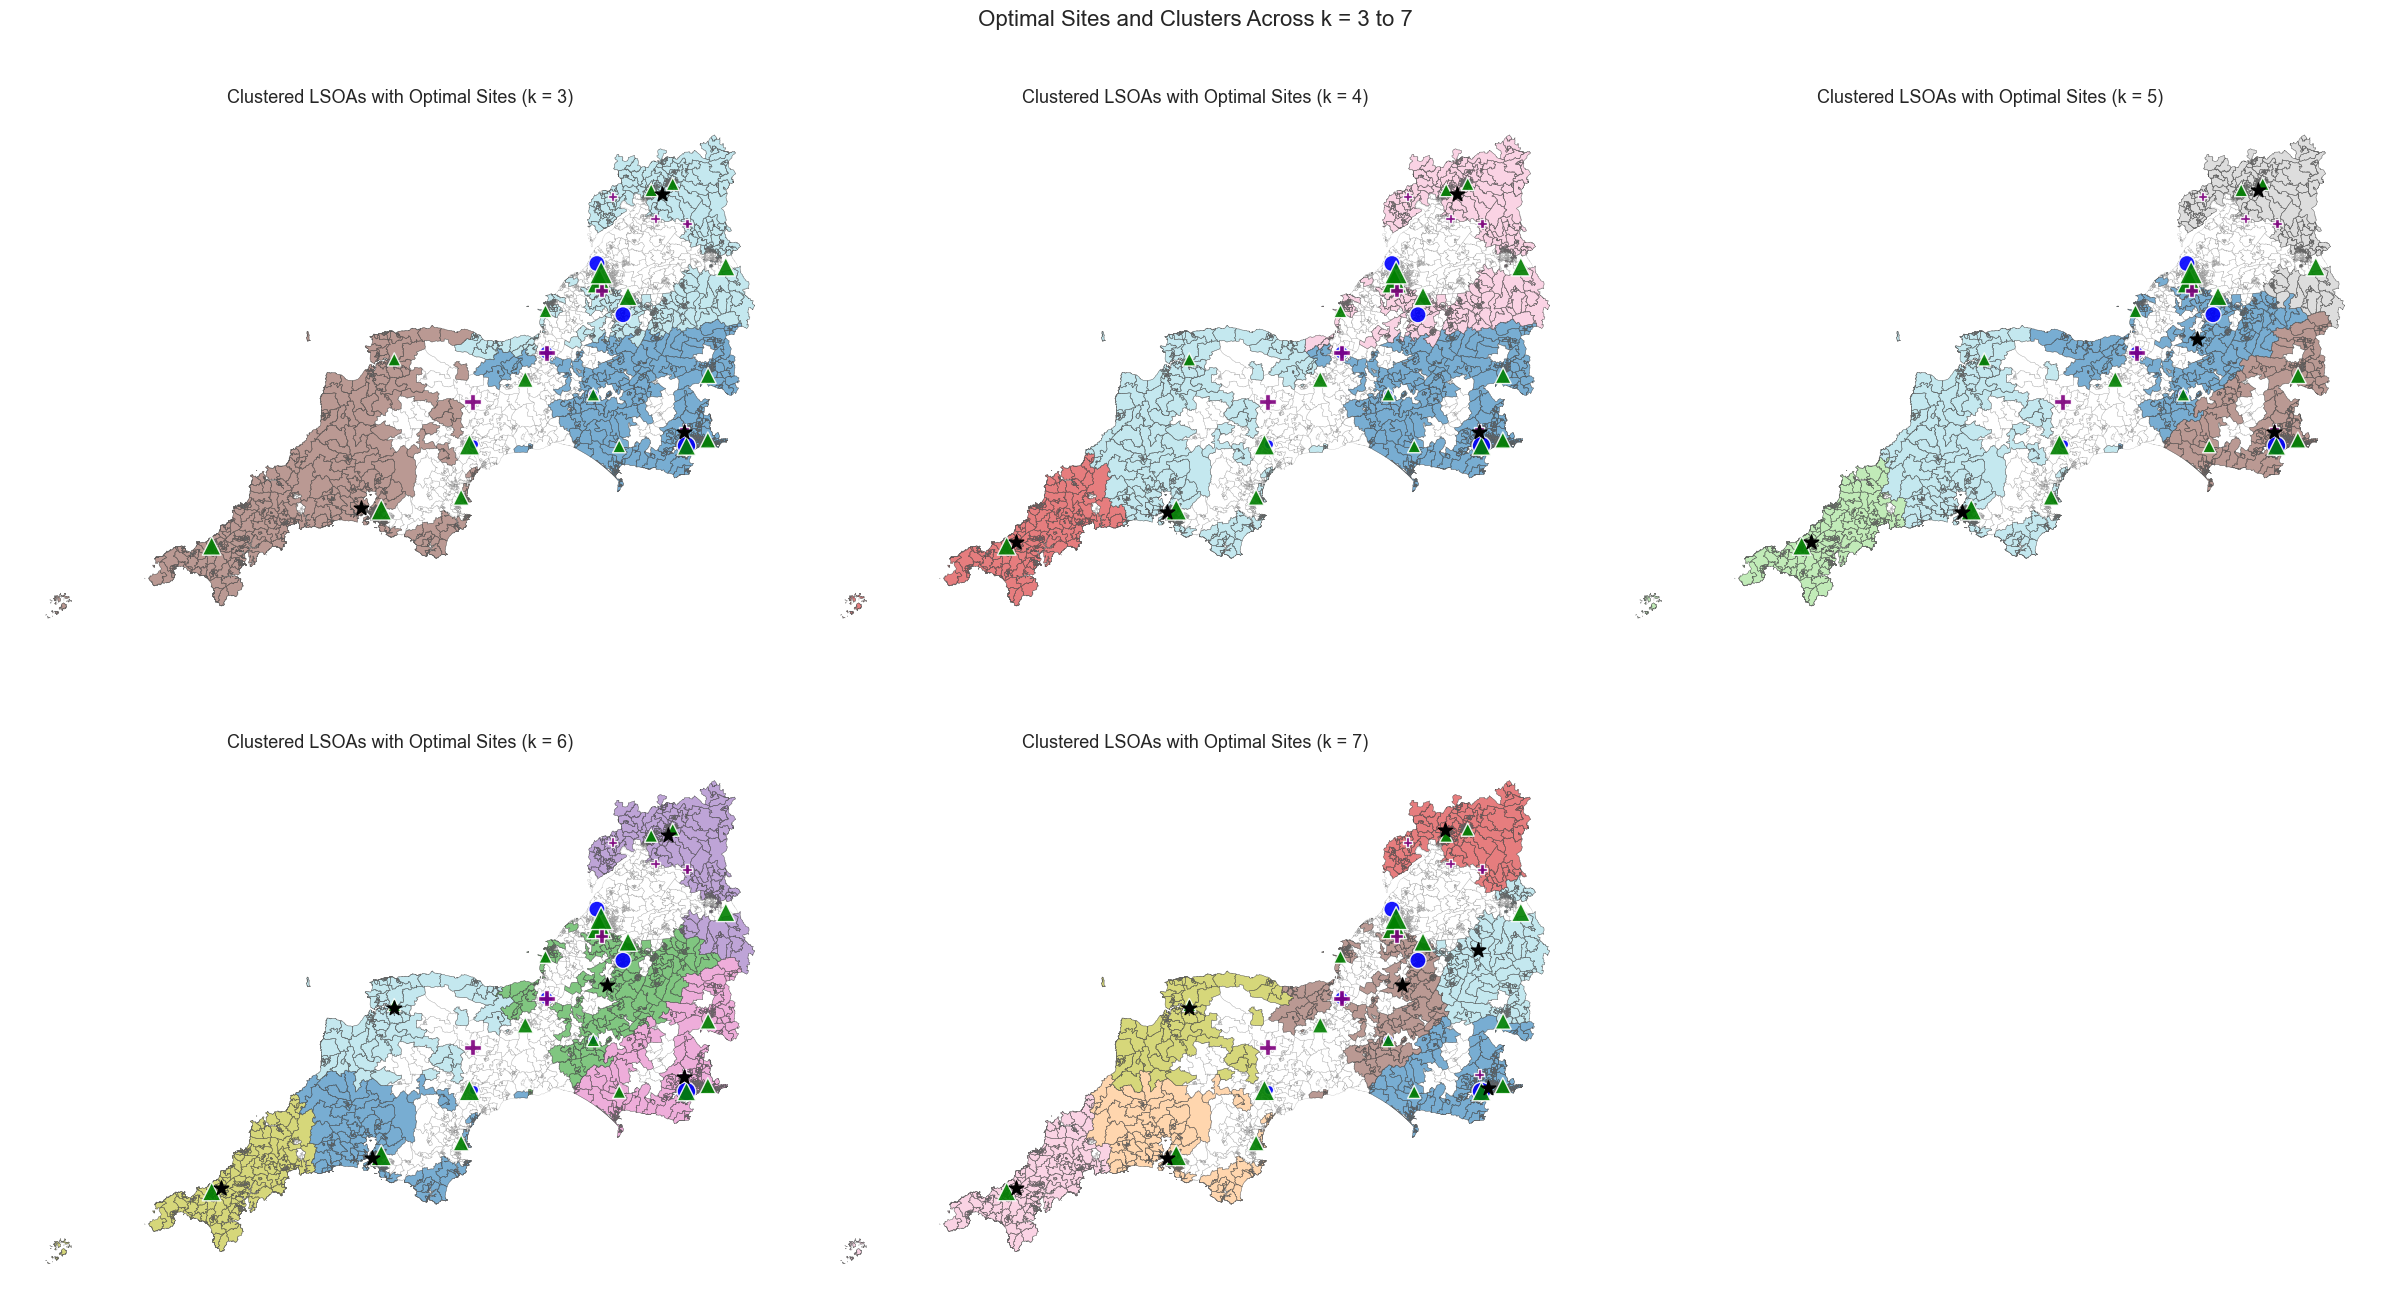

In [11]:
# ----------------------------------------------------------
# Step 2c – Prepare & Plot Optimal LSOA Sites onto Clusters (k = 3–7)
# ----------------------------------------------------------

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
axes = axes.flatten()

for i, k in enumerate(range(3, 8)):
    clustered_gdf = cluster_results[k].copy().to_crs(epsg=27700)
    optimal_sites_gdf = optimal_sites_gdf_by_k[k].copy()

    # Ensure centroid exists in cluster dataset
    if "centroid" not in clustered_gdf.columns:
        clustered_gdf["centroid"] = clustered_gdf.geometry.centroid

    # Join centroid X/Y to optimal sites
    optimal_sites_df = pd.DataFrame(optimal_sites_gdf)
    optimal_sites_df = optimal_sites_df.merge(
        clustered_gdf[["lsoa21cd", "centroid"]],
        on="lsoa21cd",
        how="left"
    )
    optimal_sites_df["centroid_x"] = optimal_sites_df["centroid"].apply(lambda p: p.x)
    optimal_sites_df["centroid_y"] = optimal_sites_df["centroid"].apply(lambda p: p.y)

    # Plot cluster map
    ax = axes[i]
    clustered_gdf.plot(
        ax=ax,
        column="cluster",
        cmap="tab20",
        linewidth=0.3,
        edgecolor="black",
        legend=False,
        alpha=0.6
    )

    # Plot optimal sites
    gpd.GeoDataFrame(
        optimal_sites_df,
        geometry=gpd.points_from_xy(optimal_sites_df["centroid_x"], optimal_sites_df["centroid_y"]),
        crs="EPSG:27700"
    ).plot(
        ax=ax,
        color="black",
        markersize=120,
        marker="*",
        label="Proposed Site (Optimal)",
        zorder=3
    )

    # Overlay current NHS facility sites
    for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
        subset = facilities_gdf[facilities_gdf["source"] == label].to_crs(epsg=27700)
        subset.plot(
            ax=ax,
            color=colour,
            markersize=subset["Endoscopy Rooms"] * 45,
            marker=marker,
            label=label,
            alpha=0.9,
            edgecolor="white",
            zorder=2
        )

    # Add base LSOA boundary
    lsoa_gdf.to_crs(epsg=27700).boundary.plot(
        ax=ax,
        linewidth=0.3,
        color="grey",
        alpha=0.4,
        zorder=1
    )

    ax.set_title(f"Clustered LSOAs with Optimal Sites (k = {k})", fontsize=13)
    ax.axis("off")

# Remove any unused axes
if len(axes) > 5:
    for j in range(5, len(axes)):
        fig.delaxes(axes[j])

plt.suptitle("Optimal Sites and Clusters Across k = 3 to 7", fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
# ----------------------------------------------------------
# Step 3 – Create and Save Uplift Files from Proposed Sites (k = 3 to 7)
# ----------------------------------------------------------

# Load LSOA geometries once and reproject to British National Grid
lsoa_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]].to_crs(epsg=27700)

for k in range(3, 8):
    print(f"\nProcessing uplift for k = {k} clusters...")

    # 1. Get optimal sites GeoDataFrame for this k
    optimal_sites_gdf = optimal_sites_gdf_by_k[k].copy()

    # 2. Convert to DataFrame for merge
    optimal_sites_df = pd.DataFrame(optimal_sites_gdf)

    # 3. Merge LSOA geometries onto optimal sites, adding suffix for geometry to avoid conflict
    optimal_sites_df = optimal_sites_df.merge(
        lsoa_geom,
        on="lsoa21cd",
        how="left",
        suffixes=('', '_geom')
    )

    # 4. Rename geometry column if needed and drop any duplicates
    if 'geometry' not in optimal_sites_df.columns and 'geometry_geom' in optimal_sites_df.columns:
        optimal_sites_df = optimal_sites_df.rename(columns={'geometry_geom': 'geometry'})
    # Drop any other geometry columns (just in case)
    for col in optimal_sites_df.columns:
        if col.startswith('geometry') and col != 'geometry':
            optimal_sites_df.drop(columns=col, inplace=True)

    # 5. Create GeoDataFrame with assigned geometry and CRS
    proposed_gdf = gpd.GeoDataFrame(
        optimal_sites_df.copy(),
        geometry="geometry",
        crs="EPSG:27700"
    )

    # 6. Add standardized facility fields
    proposed_gdf["Code"] = ["PROPOSED_" + str(i) for i in proposed_gdf.index]
    proposed_gdf["Name"] = "Proposed Site Cluster " + proposed_gdf["cluster"].astype(str)
    proposed_gdf["Endoscopy Rooms"] = 1
    proposed_gdf["postcode"] = "TBC"

    centroids = proposed_gdf.geometry.centroid
    proposed_gdf["latitude"] = centroids.y
    proposed_gdf["longitude"] = centroids.x

    proposed_gdf["msoa21cd"] = "TBC"
    proposed_gdf["oa21cd"] = "TBC"
    proposed_gdf["icb_code"] = "TBC"
    proposed_gdf["local_authority"] = "TBC"
    proposed_gdf["source"] = "Proposed"

    # 7. Reorder columns for output consistency
    proposed_gdf = proposed_gdf[
        ["Code", "Name", "Endoscopy Rooms", "postcode", "latitude", "longitude",
         "lsoa21cd", "msoa21cd", "oa21cd", "icb_code", "local_authority",
         "source", "geometry"]
    ]

    # 8. Save each proposed uplift GeoDataFrame as separate GeoPackage file
    uplift_path = os.path.join(proc_dir, f"facilities_with_proposed_sites_k{k}.gpkg")
    proposed_gdf.to_file(uplift_path, driver="GPKG")

    # 9. Report success
    print(f"Proposed uplift sites for k={k} saved ({proposed_gdf.shape[0]} sites) to: {uplift_path}")



Processing uplift for k = 3 clusters...
Proposed uplift sites for k=3 saved (3 sites) to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_with_proposed_sites_k3.gpkg

Processing uplift for k = 4 clusters...
Proposed uplift sites for k=4 saved (4 sites) to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_with_proposed_sites_k4.gpkg

Processing uplift for k = 5 clusters...
Proposed uplift sites for k=5 saved (5 sites) to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_with_proposed_sites_k5.gpkg

Processing uplift for k = 6 clusters...
Proposed uplift sites for k=6 saved (6 sites) to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/

In [13]:
# ----------------------------------------------------------
# Step 4 – Combine Original and Proposed Facilities & Save for k=3 to 7
# ----------------------------------------------------------

for k in range(3, 8):
    print(f"\nCombining and saving facilities for k = {k}...")

    # Get proposed sites GeoDataFrame for this k
    proposed_gdf = gpd.read_file(os.path.join(proc_dir, f"facilities_with_proposed_sites_k{k}.gpkg"))

    # Combine original and proposed
    all_facilities_gdf = pd.concat(
        [facilities_gdf, proposed_gdf],
        ignore_index=True
    )

    # Diagnostics
    print(f"Total combined facilities (k={k}): {all_facilities_gdf.shape[0]}")
    print(all_facilities_gdf["source"].value_counts())

    # Define output file path for combined
    combined_path = os.path.join(proc_dir, f"facilities_combined_with_proposed_k{k}.gpkg")

    # Save combined GeoDataFrame
    all_facilities_gdf.to_file(combined_path, driver="GPKG")

    print(f"Combined facility file saved for k={k} at: {combined_path}")



Combining and saving facilities for k = 3...
Total combined facilities (k=3): 35
source
Acute        18
CDC           7
Community     7
Proposed      3
Name: count, dtype: int64
Combined facility file saved for k=3 at: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_combined_with_proposed_k3.gpkg

Combining and saving facilities for k = 4...
Total combined facilities (k=4): 36
source
Acute        18
CDC           7
Community     7
Proposed      4
Name: count, dtype: int64
Combined facility file saved for k=4 at: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_combined_with_proposed_k4.gpkg

Combining and saving facilities for k = 5...
Total combined facilities (k=5): 37
source
Acute        18
CDC           7
Community     7
Proposed      5
Name: count, dtype: int64
Combined facility file sa